# waves, spring-neap cycle and dispersion

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# import scipy.integrate as integrate
# from sympy import Symbol, pi, atan, factor, lambdify

rad = 2 * np.pi
d2s = 86400
km = 1e3

print_figs = True

---

## generate space-time grid

In [2]:
def get_waves(omega=2, c=2, domega=1 / 15, dk=None, alpha=1 / 3):
    """compute an analytical signal over a spatiotemporal grid
    The signal is the sum of two propagating waves with neighbouring frequencies

    Parameters:
    -----------
    omega: float
        first wave frequency in cpd
    c: float, optional
        phase speed in m/s
    domega: float, optional
        second wave frequency offset with respect to the first one in cpd
    alpha: float, optional
        ratio of the second wave amplitude to the first one
    dk: float, optional
        second wave wavenumber offset with respect to the first one
        default to non-dispersive case
    """

    k = omega / d2s / c  # cpm
    if dk is None:
        dk = domega / d2s / c  # non-dispersive

    ds = xr.Dataset(
        coords=dict(
            x=("x", np.arange(0, 4000, 10)),
            t=("t", np.arange(0, 60, 1 / 24)),
        ),
    )

    ds["a0"] = np.exp(1j * rad * (k * ds.x * km - omega * ds.t))
    ds["a1"] = alpha * np.exp(
        1j * rad * ((k + dk) * ds.x * km - (omega + domega) * ds.t)
    )

    ds["a"] = ds["a0"] + ds["a1"]

    ds.attrs["omega"] = omega
    ds.attrs["domega"] = domega
    ds.attrs["k"] = k
    ds.attrs["dk"] = dk
    ds.attrs["c"] = c
    ds.attrs["alpha"] = alpha

    return ds

## Non dispersive wave

$domega= c \times dk$


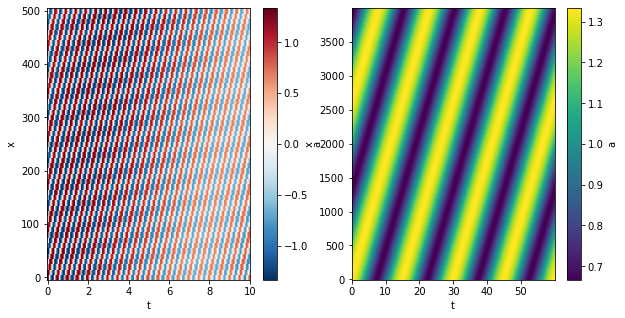

In [3]:
ds = get_waves()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
(np.real(ds["a"]).sel(t=slice(0, 10), x=slice(0, 500)).plot(ax=ax))

ax = axes[1]
np.abs(ds["a"]).plot(ax=ax)

## extremely dispersive wave: infinite group velocity

$dk=0$



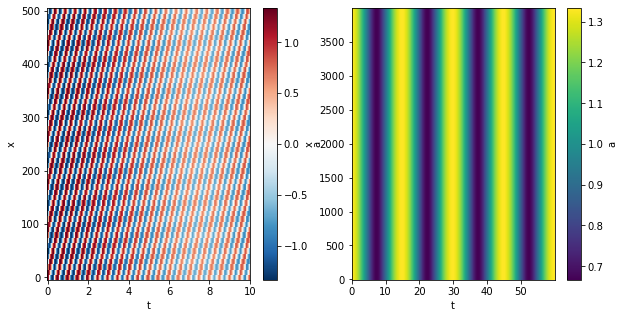

In [4]:
ds = get_waves(dk=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
(np.real(ds["a"]).sel(t=slice(0, 10), x=slice(0, 500)).plot(ax=ax))

ax = axes[1]
np.abs(ds["a"]).plot(ax=ax)

---

## low + 2 x high

In [5]:
import sstats.hfreq as hf
import sstats.tseries as ts

In [6]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
u = hf.add(u_low, u_high, u_high, labels=["low", "high0", "high1"])

In [7]:
u.autocorrelation

U_high0**2*exp(-tau/T_high0)*cos(sigma_high0*tau)/2 + U_high1**2*exp(-tau/T_high1)*cos(sigma_high1*tau)/2 + U_low**2*exp(-tau/T_low)

In [8]:
u.spectrum

T_high0*U_high0**2*(T_high0**2*(omega**2 + sigma_high0**2) + 1)/(T_high0**4*(-omega**2 + sigma_high0**2)**2 + 2*T_high0**2*(omega**2 + sigma_high0**2) + 1) + T_high1*U_high1**2*(T_high1**2*(omega**2 + sigma_high1**2) + 1)/(T_high1**4*(-omega**2 + sigma_high1**2)**2 + 2*T_high1**2*(omega**2 + sigma_high1**2) + 1) + 2*T_low*U_low**2/(T_low**2*omega**2 + 1)

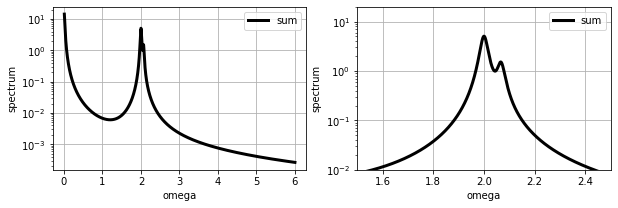

In [9]:
rad = 2 * np.pi
p_values = dict(
    **{p: 1.0 for p in u.p if p[0] == "U"},
    **{p: 10.0 for p in u.p if p[0] == "T"},
    sigma_high0=2.0 * rad,
    sigma_high1=(2.0 + 1 / 15) * rad,
    omega=dict(N=100000),
)
p_values["U_high1"] = 1 / 2
# p_values["U_high1"] = 1

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

u.plot_spectrum(
    eval_kwargs=p_values,
    label="sum",
    color="k",
    xscale="linear",
    ax=axes[0],
)

u.plot_spectrum(
    eval_kwargs=p_values,
    label="sum",
    color="k",
    xlim=(1.5, 2.5),
    ylim=(1e-2, 2 * 1e1),
    xscale="linear",
    ax=axes[1],
)

# if print_figs:
#    plt.savefig('figs/overview_lowhigh_spectrum.png')

### vary nonstationarity time scales

Base parameters:

In [29]:
p = dict(
    **{p: 1.0 for p in u.p if p[0] == "U"},
    **{p: 10.0 for p in u.p if p[0] == "T"},
    sigma_high0=2.0 * rad,
    sigma_high1=(2.0 + 1 / 15) * rad,
)
p["U_low"] = 1
p["U_high1"] = 1

In [30]:
T = [5, 10, 20]

E, R = [], []
for t in T:
    p["T_high0"] = t
    p["T_high1"] = t
    E.append(u.evaluate_spectrum(omega=dict(N=100000), **p))
    R.append(u.evaluate_autocorrelation(tau=dict(N=10000), **p))

E = xr.concat(E, dim="T_high").assign_coords(T_high=T)
R = xr.concat(R, dim="T_high").assign_coords(T_high=T)

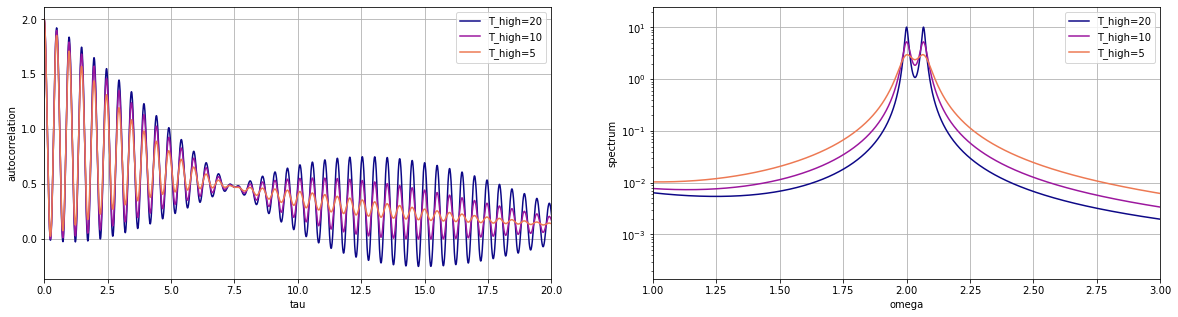

In [31]:
from sstats import get_cmap_colors

colors = get_cmap_colors(len(T))

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
for t, c in zip(T[::-1], colors):
    R.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
ax.set_xlim(0, 20)
ax.legend()
ax.set_title("")
ax.grid()


ax = axes[1]
for t, c in zip(T[::-1], colors):
    E.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 3)
ax.legend()
ax.set_title("")
ax.grid()

Same but without low frequency flow

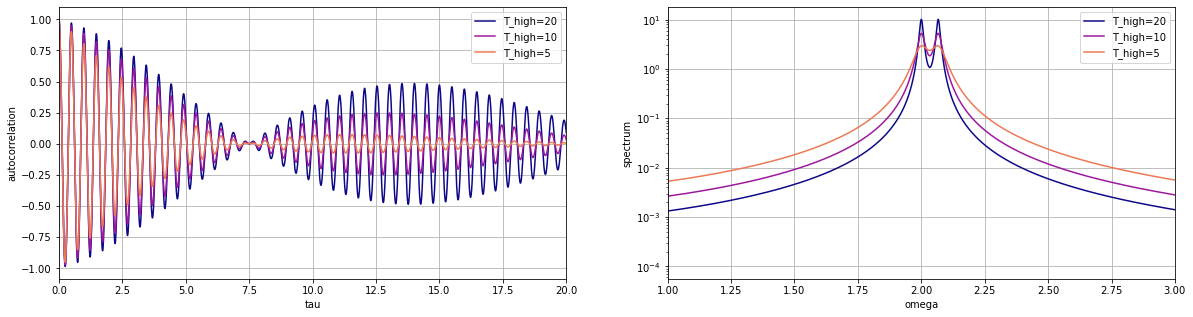

In [33]:
p["U_low"] = 0

E, R = [], []
for t in T:
    p["T_high0"] = t
    p["T_high1"] = t
    E.append(u.evaluate_spectrum(omega=dict(N=100000), **p))
    R.append(u.evaluate_autocorrelation(tau=dict(N=10000), **p))

E = xr.concat(E, dim="T_high").assign_coords(T_high=T)
R = xr.concat(R, dim="T_high").assign_coords(T_high=T)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
for t, c in zip(T[::-1], colors):
    R.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
ax.set_xlim(0, 20)
ax.legend()
ax.set_title("")
ax.grid()

ax = axes[1]
for t, c in zip(T[::-1], colors):
    E.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 3)
ax.legend()
ax.set_title("")
ax.grid()

### with gaussian decorrelation

In [34]:
u_high = hf.high_frequency_signal(model="gaussian")
u = hf.add(u_low, u_high, u_high, labels=["low", "high0", "high1"])

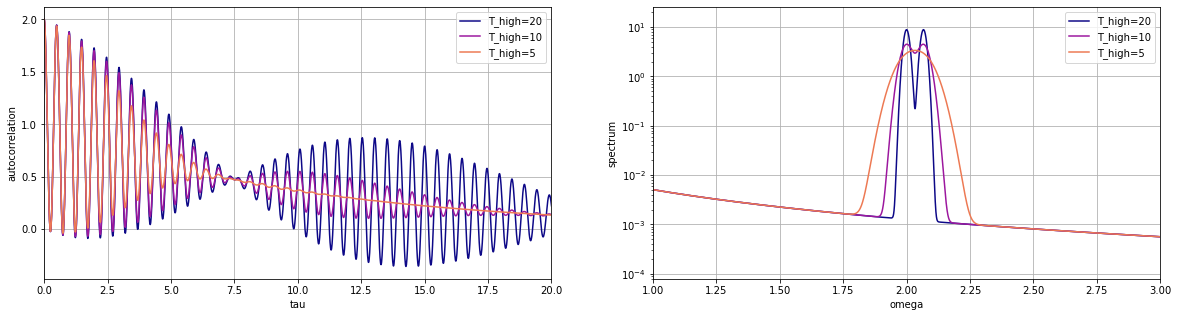

In [35]:
p = dict(
    **{p: 1.0 for p in u.p if p[0] == "U"},
    **{p: 10.0 for p in u.p if p[0] == "T"},
    sigma_high0=2.0 * rad,
    sigma_high1=(2.0 + 1 / 15) * rad,
)
p["U_low"] = 1
p["U_high1"] = 1


E, R = [], []
for t in T:
    p["T_high0"] = t
    p["T_high1"] = t
    E.append(u.evaluate_spectrum(omega=dict(N=100000), **p))
    R.append(u.evaluate_autocorrelation(tau=dict(N=10000), **p))

E = xr.concat(E, dim="T_high").assign_coords(T_high=T)
R = xr.concat(R, dim="T_high").assign_coords(T_high=T)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
for t, c in zip(T[::-1], colors):
    R.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
ax.set_xlim(0, 20)
ax.legend()
ax.set_title("")
ax.grid()

ax = axes[1]
for t, c in zip(T[::-1], colors):
    E.sel(T_high=t).plot.line(ax=ax, color=c, label=r"T_high={}".format(t))
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 3)
ax.legend()
ax.set_title("")
ax.grid()

## use synthetic time series, demodulate and compute autocorrelations